# Statistical analysis
This notebook performs differential expression analysis using the real template experiment and simulated experiments, as a null set. Then the set of differentially expressed genes (DEGs) obtained from this analysis are used to perform gene set enrichment analysis (GSEA) to identify pathways enriched in these set of DEGs.

*Note:* To run datatables, need to refresh the window and then run all cells (DO NOT restart and run all, only run all works).

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import random
import seaborn as sns
import rpy2.robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from jupyter_datatables import init_datatables_mode


def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

sys.path.append("../")
from functions import utils

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_file = os.path.abspath(os.path.join(base_dir,
                                           "Rank_pathways",
                                           "init_config.tsv"))
params = utils.read_config(config_file)

In [3]:
# User selected experiment id
project_id = "SRP000762"

In [4]:
# Load params
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
num_runs=25

In [5]:
# Load real template experiment
template_data_file = os.path.join(
    local_dir,
    "recount2_template_data.tsv")

# Load metadata file with grouping assignments for samples
metadata_file = os.path.join(
    base_dir,
    "Rank_pathways",
    "data",
    "metadata",
    "SRP000762_groups.tsv")

## Install R libraries

In [6]:
%%R
# Select 59
# Run one time
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install("limma")
#BiocManager::install('EnhancedVolcano')
#devtools::install_github('kevinblighe/EnhancedVolcano')
#BiocManager::install('clusterProfiler')
#BiocManager::install("org.Hs.eg.db")

NULL


## Differential expression analysis

In [7]:
%%R
library('limma')

**Get differentially expressed genes from template experiment**

In [8]:
%%R -i metadata_file -i project_id -i template_data_file -i local_dir

source('../functions/DE_analysis.R')

out_file <- paste(local_dir,
                  "DE_stats/DE_stats_template_data_",
                  project_id,
                  "_real.txt",
                  sep="")

if (file.exists(out_file) == FALSE){
    get_DE_stats(metadata_file,
                 project_id, 
                 template_data_file,
                 "template",
                 local_dir,
                 "real")
    }

**Get differentially expressed genes from each simulated experiment**

In [9]:
%%R -i metadata_file -i project_id -i base_dir -i local_dir -i num_runs -o num_sign_DEGs_simulated

source('../functions/DE_analysis.R')

num_sign_DEGs_simulated <- c()

for (i in 0:(num_runs-1)){
    simulated_data_file <- paste(local_dir, 
                                 "pseudo_experiment/selected_simulated_data_",
                                 project_id,
                                 "_", 
                                 i,
                                 ".txt",
                                 sep="")
    out_file <- paste(local_dir, 
                      "DE_stats/DE_stats_simulated_data_",
                      project_id,
                      "_",
                      i,
                      ".txt", 
                      sep="")
    
    if (file.exists(out_file) == FALSE){
        run_output <- get_DE_stats(metadata_file,
                                   project_id, 
                                   simulated_data_file,
                                   "simulated",
                                   local_dir,
                                   i)
        num_sign_DEGs_simulated <- c(num_sign_DEGs_simulated, run_output)
    } else {
        # Read in DE stats data
        DE_stats_data <- as.data.frame(read.table(out_file, sep="\t", header=TRUE, row.names=1))
        
        # Get number of genes that exceed threshold
        threshold <- 0.05
        sign_DEGs <- DE_stats_data[DE_stats_data[,'adj.P.Val']<threshold,]
        
        num_sign_DEGs <- nrow(sign_DEGs)
        
        num_sign_DEGs_simulated <- c(num_sign_DEGs_simulated, num_sign_DEGs)
    }
}

2020-05-20 17:31:24,790 [461] WARNING  py.warnings:110: [JupyterRequire] /home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



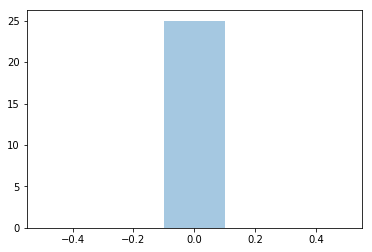

In [10]:
# Plot distribution of differentially expressed genes for simulated experiments
sns.distplot(num_sign_DEGs_simulated,
            kde=False)

**Observation:** All simulated experiments found 0 DEGs using adjusted p-value cutoff of <5%

**Check**

As a check, we compared the number of DEGs identified here versus what was reported in the [Reddy et. al. publication](https://www.ncbi.nlm.nih.gov//pubmed/19801529), which found:
* 234 genes with a significant (FDR < 5%) change in expression in response to DEX treatment. 
* After removing pseudogenes (listed in Supplemental Table S3), 209 differentially expressed genes remained 
* Of the DEX-responsive genes, more showed increases in transcript levels 123 (59%) than showed decreases 86 (41%), and the up-regulation was slightly but significantly stronger than the down-regulation

By comparison:
* Our study found 60 DEGs instead of 234. 
* Spot checking the genes identified with their list of DEX-responsive genes (Supplementary Dataset 2), we found the same genes and FC direction was consistent though magnitudes of theirs was lower compared to ours. 

In [11]:
# Load association statistics for template experiment
template_DE_stats_file = os.path.join(
    local_dir,
    "DE_stats",
    "DE_stats_template_data_"+project_id+"_real.txt")

In [12]:
template_DE_stats = pd.read_csv(
    template_DE_stats_file,
    header=0,
    sep='\t',
    index_col=0)

template_DEGs = template_DE_stats[template_DE_stats['adj.P.Val']<0.05]
print(template_DEGs.shape)
template_DEGs.head()

(60, 6)


,logFC,AveExpr,t,P.Value,adj.P.Val,B
ENSG00000067082.14,19.385246,18.673139,14.055682,2.342010e-12,1.359233e-07,9.739709
ENSG00000177606.6,-8.236487,9.185753,-13.126898,8.859555e-12,2.570910e-07,9.292456
ENSG00000114315.3,-6.285228,6.042663,-12.840532,1.355507e-11,2.622318e-07,9.141666
ENSG00000185950.8,8.790781,17.705828,12.594113,1.966140e-11,2.852721e-07,9.006626
ENSG00000095752.6,-7.505790,7.299177,-12.204218,3.582671e-11,4.158550e-07,8.782431


In [13]:
#%%R
#library(EnhancedVolcano)

In [14]:
#%%R -i project_id -i template_DE_stats_file -i local_dir

#source('../functions/DE_analysis.R')

#create_volcano(template_DE_stats_file,
#               project_id,
#               "adj.P.Val",
#               local_dir)

## Gene set enrichment analysis

**Goal:** To detect modest but coordinated changes in prespecified sets of related genes (i.e. those genes in the same pathway or share the same GO term).

1. Ranks all genes based using DE association statistics. In this case we used the p-value scores to rank genes. logFC returned error -- need to look into this.
2. An enrichment score (ES) is defined as the maximum distance from the middle of the ranked list. Thus, the enrichment score indicates whether the genes contained in a gene set are clustered towards the beginning or the end of the ranked list (indicating a correlation with change in expression). 
3. Estimate the statistical significance of the ES by a phenotypic-based permutation test in order to produce a null distribution for the ES( i.e. scores based on permuted phenotype)

**Note:** Since there were 0 differentially expressed genes using simulated experiments, we used gene set enrichement analysis instead of over-representation analysis to get ranking of genes

In [15]:
%%R
suppressWarnings(library(clusterProfiler))
suppressWarnings(library(org.Hs.eg.db))
suppressWarnings(library(DOSE))

2020-05-20 17:31:26,932 [461] WARNING  py.warnings:110: [JupyterRequire] /home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)

2020-05-20 17:31:28,211 [461] WARNING  py.warnings:110: [JupyterRequire] /home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 method overwritten by 'enrichplot':
  method               from
  fortify.enrichResult DOSE

  warnings.warn(x, RRuntimeWarning)

2020-05-20 17:31:28,246 [461] WARNING  py.warnings:110: [JupyterRequire] /home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: clusterProfiler v3.14.3  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfile

**Get pathway enrichment for template experiment**

In [16]:
%%R -i template_DE_stats_file  -o template_enriched_pathways

source('../functions/GSEA_analysis.R')

template_enriched_pathways <- find_enriched_pathways(template_DE_stats_file)

2020-05-20 17:32:17,664 [461] WARNING  py.warnings:110: [JupyterRequire] /home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)



In [17]:
print(template_enriched_pathways.shape)
template_enriched_pathways.head()

(914, 12)


,ONTOLOGY,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalues,rank,leading_edge,core_enrichment
0,BP,GO:0000070,mitotic sister chromatid segregation,152,0.515293,1.604690,0.000999,0.01635,0.013268,16866,"tags=52%, list=29%, signal=37%",ENSG00000154473/ENSG00000121152/ENSG0000016784...
1,BP,GO:0000075,cell cycle checkpoint,215,0.486637,1.538099,0.000999,0.01635,0.013268,16017,"tags=47%, list=28%, signal=34%",ENSG00000182973/ENSG00000154473/ENSG0000016841...
2,BP,GO:0000077,DNA damage checkpoint,144,0.487972,1.516285,0.000999,0.01635,0.013268,17564,"tags=49%, list=30%, signal=34%",ENSG00000182973/ENSG00000168411/ENSG0000013984...
3,BP,GO:0000082,G1/S transition of mitotic cell cycle,267,0.439629,1.398898,0.000999,0.01635,0.013268,14089,"tags=37%, list=24%, signal=28%",ENSG00000198987/ENSG00000199157/ENSG0000020759...
4,BP,GO:0000086,G2/M transition of mitotic cell cycle,244,0.508493,1.614165,0.000999,0.01635,0.013268,14763,"tags=48%, list=25%, signal=36%",ENSG00000196230/ENSG00000139289/ENSG0000017520...


**Get pathway enrichment for simulated experiments**

In [18]:
%%R -i project_id -i local_dir -i num_runs 

source('../functions/GSEA_analysis.R')

for (i in 0:(num_runs-1)){
    simulated_DE_stats_file <- paste(local_dir, 
                                 "DE_stats/DE_stats_simulated_data_", 
                                 project_id,
                                 "_", 
                                 i,
                                 ".txt",
                                 sep="")
    
    out_file = paste(local_dir, 
                     "GSEA_stats/GSEA_simulated_data_",
                     project_id,
                     "_",
                     i,
                     ".txt", 
                     sep="")
    
    if (file.exists(out_file) == FALSE){
        enriched_pathways <- find_enriched_pathways(simulated_DE_stats_file) 
    
        write.table(enriched_pathways, file = out_file, row.names = T, sep = "\t", quote = F)
        }
    }

## Statistics

**Template experiment**

In [19]:
col_to_rank = 'enrichmentScore'

In [20]:
# Get ranks of template experiment
# Rank pathways by highest enrichment score
template_enriched_pathways['ranking'] = template_enriched_pathways[col_to_rank].rank(ascending = 0) 
template_enriched_pathways = template_enriched_pathways.sort_values(by=col_to_rank, ascending=False)

# Set index to GO ID
template_enriched_pathways.set_index("ID", inplace=True)
print(template_enriched_pathways.shape)
template_enriched_pathways.head()

(914, 12)


,ONTOLOGY,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalues,rank,leading_edge,core_enrichment,ranking
ID,,,,,,,,,,,,
GO:0017166,MF,vinculin binding,11,0.764407,1.823127,0.001058,0.016639,0.013503,8431,"tags=64%, list=15%, signal=54%",ENSG00000137076/ENSG00000173402/ENSG0000008915...,1.0
GO:0019774,CC,"proteasome core complex, beta-subunit complex",11,0.756475,1.804210,0.001058,0.016639,0.013503,10764,"tags=73%, list=19%, signal=59%",ENSG00000126067/ENSG00000159377/ENSG0000024006...,2.0
GO:0005763,CC,mitochondrial small ribosomal subunit,28,0.744290,2.052372,0.001001,0.016350,0.013268,12851,"tags=75%, list=22%, signal=58%",ENSG00000135972/ENSG00000132676/ENSG0000006258...,3.5
GO:0000314,CC,organellar small ribosomal subunit,28,0.744290,2.052372,0.001001,0.016350,0.013268,12851,"tags=75%, list=22%, signal=58%",ENSG00000135972/ENSG00000132676/ENSG0000006258...,3.5
GO:0000805,CC,X chromosome,10,0.741553,1.721130,0.002160,0.029290,0.023769,10394,"tags=60%, list=18%, signal=49%",ENSG00000121931/ENSG00000132475/ENSG0000012337...,5.0


In [21]:
# Check that GO IDs are unique
template_enriched_pathways.index.nunique() == len(template_enriched_pathways)

True

**Check**

Again, we want to compare our ranked pathways found against what was reported in the original publication.

*The DEX-responsive genes that we identified are primarily implicated in two broad classes: stress response and development (Table 1; Reimand et al. 2007). Comparison to Gene Ontology (GO) categories (Ashburner et al. 2000) revealed that the identified genes are involved in stress response (P = 6 × 10−11), organ development (P = 5 × 10−15), cell differentiation (P = 1 × 10−11), hormone secretion (P = 4 × 10−7), and apoptosis (P = 5 × 10−12).*

We found pathways that are consistent with what publication found: pathways related to anatomical structure (i.e. vinculin, ) and cell differentiation (i.e. centromeric sister chromatid cohesion), hormone secretion (i.e. somatic hypermutation of immunoglobulin genes)

**Simulated experiments**

In [22]:
# Concatenate simulated experiments
simulated_enriched_pathways_all = pd.DataFrame()
for i in range(num_runs):
    simulated_GSEA_file = os.path.join(
        local_dir, 
        "GSEA_stats",
        "GSEA_simulated_data_"+project_id+"_"+str(i)+".txt")
    
    #Read results
    simulated_enriched_pathways = pd.read_csv(
        simulated_GSEA_file,
        header=0,
        sep='\t',
        index_col=0)
    
    # Add ranks of simulated experiment
    simulated_enriched_pathways['ranking'] = simulated_enriched_pathways[col_to_rank].rank(ascending = 0) 
    simulated_enriched_pathways = simulated_enriched_pathways.sort_values(by=col_to_rank, ascending=False)
    
    # Concatenate df
    simulated_enriched_pathways_all = pd.concat([simulated_enriched_pathways_all,
                                       simulated_enriched_pathways])
    
print(simulated_enriched_pathways_all.shape)
simulated_enriched_pathways_all.head()

(42136, 13)


,ONTOLOGY,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalues,rank,leading_edge,core_enrichment,ranking
GO:0000353,BP,GO:0000353,formation of quadruple SL/U4/U5/U6 snRNP,12,0.765343,1.817596,0.001047,0.005979,0.003670,13628,"tags=100%, list=23%, signal=77%",ENSG00000199377/ENSG00000200156/ENSG0000020735...,2.0
GO:0045291,BP,GO:0045291,"mRNA trans splicing, SL addition",12,0.765343,1.817596,0.001047,0.005979,0.003670,13628,"tags=100%, list=23%, signal=77%",ENSG00000199377/ENSG00000200156/ENSG0000020735...,2.0
GO:0000365,BP,GO:0000365,"mRNA trans splicing, via spliceosome",12,0.765343,1.817596,0.001047,0.005979,0.003670,13628,"tags=100%, list=23%, signal=77%",ENSG00000199377/ENSG00000200156/ENSG0000020735...,2.0
GO:1904851,BP,GO:1904851,positive regulation of establishment of protei...,10,0.762148,1.749047,0.002128,0.010340,0.006347,12577,"tags=90%, list=22%, signal=71%",ENSG00000120438/ENSG00000130826/ENSG0000015075...,5.0
GO:1903405,BP,GO:1903405,protein localization to nuclear body,10,0.762148,1.749047,0.002128,0.010340,0.006347,12577,"tags=90%, list=22%, signal=71%",ENSG00000120438/ENSG00000130826/ENSG0000015075...,5.0


In [23]:
simulated_enriched_pathways_stats = simulated_enriched_pathways_all.groupby(['ID'])[['enrichmentScore', 'pvalue', 'ranking']].agg({
    col_to_rank:['mean', 'std','count'],
    'pvalue':['median'],
    'ranking':['median']
})

simulated_enriched_pathways_stats.head()

enrichmentScore                    pvalue ranking
                      mean       std count    median  median
ID                                                          
GO:0000018        0.441868  0.016700     4  0.005495  1919.0
GO:0000027        0.548594  0.021737     4  0.006503   328.5
GO:0000028        0.573867  0.056410     5  0.007121   113.0
GO:0000038        0.535535       NaN     1  0.009009   415.0
GO:0000041        0.449833  0.019520    11  0.001998  1167.0

In [24]:
# Merge template statistics with simulated statistics
template_simulated_enriched_pathways_stats = template_enriched_pathways.merge(simulated_enriched_pathways_stats, 
                                                                              how='outer',
                                                                              left_index=True,
                                                                              right_index=True)
template_simulated_enriched_pathways_stats.head()

2020-05-20 17:32:18,780 [461] WARNING  py.warnings:110: [JupyterRequire] /home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)



,ONTOLOGY,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalues,rank,leading_edge,core_enrichment,ranking,"(enrichmentScore, mean)","(enrichmentScore, std)","(enrichmentScore, count)","(pvalue, median)","(ranking, median)"
ID,,,,,,,,,,,,,,,,,
GO:0000018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.441868,0.016700,4.0,0.005495,1919.0
GO:0000027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.548594,0.021737,4.0,0.006503,328.5
GO:0000028,BP,ribosomal small subunit assembly,18.0,0.628994,1.622578,0.005097,0.047097,0.038218,14890.0,"tags=56%, list=26%, signal=41%",ENSG00000083845/ENSG00000115268/ENSG0000013259...,84.0,0.573867,0.056410,5.0,0.007121,113.0
GO:0000038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.535535,NaN,1.0,0.009009,415.0
GO:0000041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.449833,0.019520,11.0,0.001998,1167.0


In [25]:
# Parse columns
median_pval_simulated = template_simulated_enriched_pathways_stats[('pvalue','median')]
median_rank_simulated = template_simulated_enriched_pathways_stats[('ranking','median')]
mean_test_simulated = template_simulated_enriched_pathways_stats[(col_to_rank,'mean')]
std_test_simulated = template_simulated_enriched_pathways_stats[(col_to_rank,'std')]

## Examine enriched pathways
Examine the enriched pathways identified from template experiment -- How are these enriched pathways ranked in the simulated experiments?

Recall that there were 25 simulated experiments

### Calculations for summary table

In [27]:
init_datatables_mode()

<JupyterRequire.display.SafeScript object>

<JupyterRequire.display.SafeScript object>

<JupyterRequire.display.SafeScript object>

In [30]:
summary = pd.DataFrame(data={'GO ID': template_simulated_enriched_pathways_stats.index,
                             'Pathway': template_simulated_enriched_pathways_stats['Description'],
                             'P-value (Real)': template_simulated_enriched_pathways_stats['pvalue'],
                             'Rank (Real)': template_simulated_enriched_pathways_stats['ranking'],
                             'Test statistic (Real)': template_enriched_pathways[col_to_rank],
                             'Median p-value (simulated)': median_pval_simulated ,
                             'Median rank (simulated)': median_rank_simulated ,
                             'Mean test statistic (simulated)': mean_test_simulated ,
                             'Std deviation (simulated)': std_test_simulated
                            }
                      )
summary['Z score'] = (summary['Test statistic (Real)'] - summary['Mean test statistic (simulated)'])/summary['Std deviation (simulated)']
summary

<JupyterRequire.display.SafeScript object>

,GO ID,Pathway,P-value (Real),Rank (Real),Test statistic (Real),Median p-value (simulated),Median rank (simulated),Mean test statistic (simulated),Std deviation (simulated),Z score
GO:0000018,GO:0000018,NaN,NaN,NaN,NaN,0.005495,1919.0,0.441868,0.016700,NaN
GO:0000027,GO:0000027,NaN,NaN,NaN,NaN,0.006503,328.5,0.548594,0.021737,NaN
GO:0000028,GO:0000028,ribosomal small subunit assembly,0.005097,84.0,0.628994,0.007121,113.0,0.573867,0.056410,0.977254
GO:0000038,GO:0000038,NaN,NaN,NaN,NaN,0.009009,415.0,0.535535,NaN,NaN
GO:0000041,GO:0000041,NaN,NaN,NaN,NaN,0.001998,1167.0,0.449833,0.019520,NaN
GO:0000045,GO:0000045,NaN,NaN,NaN,NaN,0.007503,1877.5,0.415553,0.074887,NaN
GO:0000049,GO:0000049,tRNA binding,0.002997,308.0,0.525192,0.009491,1201.0,0.472127,0.004882,10.870066
GO:0000050,GO:0000050,NaN,NaN,NaN,NaN,0.002092,28.0,0.698310,NaN,NaN
GO:0000054,GO:0000054,NaN,NaN,NaN,NaN,0.010373,109.5,0.632219,0.004196,NaN
GO:0000070,GO:0000070,mitotic sister chromatid segregation,0.000999,341.0,0.515293,0.000999,809.0,0.464635,0.043823,1.155955


In [29]:
# Save file
summary_file = os.path.join(
        local_dir, 
        "summary_table.tsv")

summary.to_csv(summary_file, float_format='%.5f', sep='\t')

There are a few immune pathways that are template-enriched but there are others that look to be involved in cellular maintenancem, which I wouldn't expect to be specific to these experiment.

For GSEA I am currently using the p-values from the DE analysis to rank genes, should I try using avg gene expression instead..? Maybe p-values don't cluster genes as much..?

Note: this notebook takes ~1hr to run

**Check:**
* Are there template-specific pathways (i.e. pathways specific to Dexamethasone treatment) that we can use as a positive?
* Are there agnostic pathways that we can use as a negative control?